<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/directional_graphDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try Directional Graph DB

* Download the data from https://cdn.analyticsvidhya.com/wp-content/uploads/2020/01/ipl_batting_partnerships.csv

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ipl_batting_partnerships.csv", index_col='index')
print(df.shape)
df.head()

(424, 5)


,team,player_1,player_2,score_1,score_2
index,,,,,
0,Chennai Super Kings,AT Rayudu,SR Watson,7,0
1,Chennai Super Kings,AT Rayudu,SK Raina,12,19
2,Chennai Super Kings,AT Rayudu,KM Jadhav,9,9
3,Chennai Super Kings,RA Jadeja,KM Jadhav,6,4
19,Sunrisers Hyderabad,DA Warner,JM Bairstow,74,39


## Build Graph DB

* Calculate median score of each player in a partnership
* In a partnership, the player contributed higher percentage of the score is the lead, and in the graph, the arrow should point to the lead in a relationship

In [4]:
partner_df = df[['player_1', 'player_2']].drop_duplicates()
print(partner_df.shape)

partner_df.head()

(185, 2)


,player_1,player_2
index,,
0,AT Rayudu,SR Watson
1,AT Rayudu,SK Raina
2,AT Rayudu,KM Jadhav
3,RA Jadeja,KM Jadhav
19,DA Warner,JM Bairstow


In [5]:
play1_median_score_df = df[['player_1', 'score_1']].groupby(['player_1'],
                                                    as_index=False)['score_1']\
                        .agg(['median']).reset_index()

play1_median_score_df = play1_median_score_df.rename(index=str, columns={'median': 'median_score_1'})
print(play1_median_score_df.shape)
play1_median_score_df.head()

(56, 2)


,player_1,median_score_1
0,A Mishra,2.5
1,AR Patel,3.0
2,AS Joseph,3.0
3,AT Rayudu,5.0
4,Avesh Khan,0.0


In [6]:
play2_median_score_df = df[['player_2', 'score_2']].groupby(['player_2'],
                                                    as_index=False)['score_2']\
                        .agg(['median']).reset_index()

play2_median_score_df = play2_median_score_df.rename(index=str, 
                                        columns={'median': 'median_score_2'})
print(play2_median_score_df.shape)
play2_median_score_df.head()

(63, 2)


,player_2,median_score_2
0,AR Patel,4.0
1,AS Joseph,6.0
2,AT Rayudu,21.0
3,Abhishek Sharma,1.0
4,Avesh Khan,4.0


In [7]:
partner_df = partner_df.merge(play1_median_score_df, on='player_1', how='left')
print(partner_df.shape)

partner_df.head()

(185, 3)


,player_1,player_2,median_score_1
0,AT Rayudu,SR Watson,5.0
1,AT Rayudu,SK Raina,5.0
2,AT Rayudu,KM Jadhav,5.0
3,RA Jadeja,KM Jadhav,0.5
4,DA Warner,JM Bairstow,15.0


In [8]:
partner_df = partner_df.merge(play2_median_score_df, on='player_2', how='left')
print(partner_df.shape)

partner_df.head()

(185, 4)


,player_1,player_2,median_score_1,median_score_2
0,AT Rayudu,SR Watson,5.0,2.0
1,AT Rayudu,SK Raina,5.0,11.0
2,AT Rayudu,KM Jadhav,5.0,8.5
3,RA Jadeja,KM Jadhav,0.5,8.5
4,DA Warner,JM Bairstow,15.0,18.5


In [9]:
partner_df['lead'] = np.where(partner_df['median_score_1'] >= partner_df['median_score_2'], 
                              partner_df['player_1'], partner_df['player_2'])
partner_df['follower'] = np.where(partner_df['lead']==partner_df['player_1'], 
                                  partner_df['player_2'], partner_df['player_1'])
partner_df['higher_score'] = np.where(partner_df['median_score_1'] > partner_df['median_score_2'],
                                      partner_df['median_score_1'], 
                                      partner_df['median_score_2'])
partner_df['total_score'] = partner_df['median_score_1'] + partner_df['median_score_2']
partner_df['performance'] = partner_df['higher_score']/(partner_df['total_score'] + 0.001)

partner_df.head()

,player_1,player_2,median_score_1,median_score_2,lead,follower,higher_score,total_score,performance
0,AT Rayudu,SR Watson,5.0,2.0,AT Rayudu,SR Watson,5.0,7.0,0.714184
1,AT Rayudu,SK Raina,5.0,11.0,SK Raina,AT Rayudu,11.0,16.0,0.687457
2,AT Rayudu,KM Jadhav,5.0,8.5,KM Jadhav,AT Rayudu,8.5,13.5,0.629583
3,RA Jadeja,KM Jadhav,0.5,8.5,KM Jadhav,RA Jadeja,8.5,9.0,0.944340
4,DA Warner,JM Bairstow,15.0,18.5,JM Bairstow,DA Warner,18.5,33.5,0.552222


In [10]:
G = nx.from_pandas_edgelist(partner_df, "follower", "lead", ['performance'], 
                            create_using=nx.MultiDiGraph())

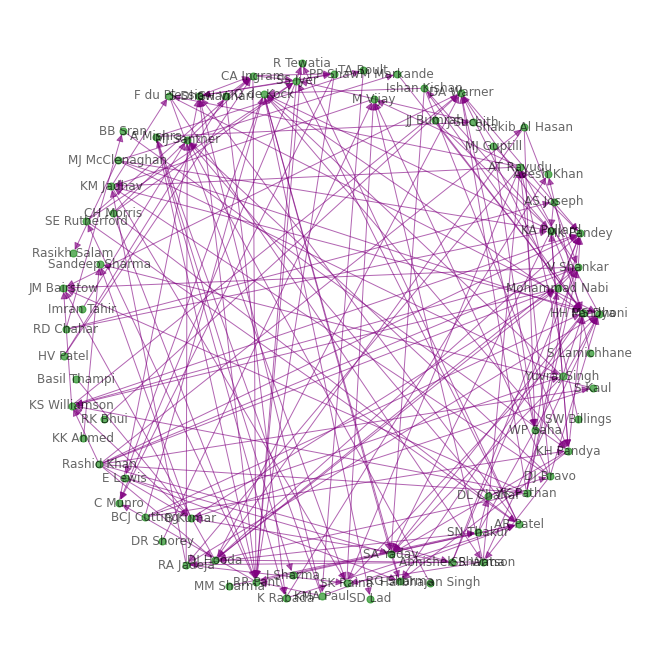

In [15]:
plt.figure(figsize=(9,9))
pos = nx.spring_layout(G, k = 100, seed = 10) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='green', node_size=50, pos = pos,
        edgelist=G.edges(), edge_color='purple', arrowsize=15, alpha=0.6)
plt.show()

In [31]:
# get the edge weights
weights = list(nx.get_edge_attributes(G, 'performance').values())
print(weights[0:4])

[0.714183688044565, 0.5789168991105731, 0.5675368898978433, 0.8888395089161713]


In [40]:
for u, v, data in G.in_edges(data=True):
  print(u,v,data)
  break

F du Plessis SR Watson {'performance': 0.5713877580172845}


In [41]:
for u, v, data in G.out_edges(data=True):
  print(u,v,data)
  break

SR Watson AT Rayudu {'performance': 0.714183688044565}


In [35]:
# find the partnership with the highest weight
partnership_dct = nx.get_edge_attributes(G, 'performance')
sorted_partnership = {k: v for k, v in sorted(partnership_dct.items(),
                                              key=lambda item: item[1], 
                                              reverse=True)}
print(sorted_partnership)

{('JJ Bumrah', 'HH Pandya', 0): 0.9999230828397816, ('MM Sharma', 'SN Thakur', 0): 0.9999090991728026, ('Rashid Khan', 'MK Pandey', 0): 0.9998889012331964, ('Rashid Khan', 'KS Williamson', 0): 0.9998750156230471, ('JJ Bumrah', 'KA Pollard', 0): 0.9998333611064822, ('Rashid Khan', 'Mohammad Nabi', 0): 0.9998333611064822, ('Imran Tahir', 'MJ Santner', 0): 0.9998333611064822, ('SW Billings', 'AT Rayudu', 0): 0.9998000399920015, ('GH Vihari', 'K Rabada', 0): 0.9997778271495222, ('HV Patel', 'CA Ingram', 0): 0.9997500624843788, ('CH Morris', 'CA Ingram', 0): 0.9997500624843788, ('I Sharma', 'AR Patel', 0): 0.9997500624843788, ('Rashid Khan', 'YK Pathan', 0): 0.9996667777407531, ('S Kaul', 'Sandeep Sharma', 0): 0.9996667777407531, ('Rashid Khan', 'Shakib Al Hasan', 0): 0.9996001599360256, ('HV Patel', 'GH Vihari', 0): 0.9995002498750625, ('Rashid Khan', 'V Shankar', 0): 0.999333777481679, ('Rashid Khan', 'DJ Hooda', 0): 0.999333777481679, ('Rashid Khan', 'Abhishek Sharma', 0): 0.999000999000

In [44]:
for u, v, data in G.in_edges(data=True):
  if data['performance']>=0.999923:
    print(u,v,data)
    break

for u, v, data in G.out_edges(data=True):
  if data['performance']>=0.999923:
    print(u,v,data)
    break

JJ Bumrah HH Pandya {'performance': 0.9999230828397816}
JJ Bumrah HH Pandya {'performance': 0.9999230828397816}


In [45]:
G.degree

DiMultiDegreeView({'SR Watson': 7, 'AT Rayudu': 9, 'SK Raina': 7, 'KM Jadhav': 7, 'RA Jadeja': 7, 'DA Warner': 9, 'JM Bairstow': 5, 'V Shankar': 10, 'YK Pathan': 8, 'MK Pandey': 9, 'RG Sharma': 5, 'Q de Kock': 10, 'SA Yadav': 8, 'Yuvraj Singh': 7, 'KA Pollard': 10, 'HH Pandya': 11, 'KH Pandya': 9, 'BCJ Cutting': 4, 'MJ McClenaghan': 5, 'Rasikh Salam': 1, 'PP Shaw': 5, 'S Dhawan': 7, 'SS Iyer': 10, 'CA Ingram': 8, 'RR Pant': 11, 'KMA Paul': 5, 'AR Patel': 9, 'R Tewatia': 3, 'MS Dhoni': 8, 'DJ Bravo': 7, 'M Markande': 2, 'JJ Bumrah': 2, 'KS Williamson': 8, 'Rashid Khan': 10, 'GH Vihari': 3, 'HV Patel': 2, 'CH Morris': 4, 'K Rabada': 4, 'Avesh Khan': 2, 'S Lamichhane': 1, 'DL Chahar': 3, 'SN Thakur': 4, 'MM Sharma': 1, 'DJ Hooda': 9, 'Mohammad Nabi': 8, 'I Sharma': 2, 'F du Plessis': 5, 'B Kumar': 7, 'S Kaul': 3, 'Sandeep Sharma': 3, 'Ishan Kishan': 5, 'RD Chahar': 3, 'AS Joseph': 2, 'SD Lad': 1, 'MJ Santner': 5, 'RK Bhui': 1, 'Abhishek Sharma': 5, 'KK Ahmed': 1, 'C Munro': 4, 'SW Billing

In [46]:
G.in_degree

InMultiDegreeView({'SR Watson': 2, 'AT Rayudu': 4, 'SK Raina': 5, 'KM Jadhav': 4, 'RA Jadeja': 2, 'DA Warner': 6, 'JM Bairstow': 5, 'V Shankar': 5, 'YK Pathan': 1, 'MK Pandey': 9, 'RG Sharma': 4, 'Q de Kock': 5, 'SA Yadav': 7, 'Yuvraj Singh': 2, 'KA Pollard': 5, 'HH Pandya': 9, 'KH Pandya': 6, 'BCJ Cutting': 0, 'MJ McClenaghan': 0, 'Rasikh Salam': 1, 'PP Shaw': 2, 'S Dhawan': 6, 'SS Iyer': 5, 'CA Ingram': 5, 'RR Pant': 8, 'KMA Paul': 1, 'AR Patel': 5, 'R Tewatia': 2, 'MS Dhoni': 7, 'DJ Bravo': 1, 'M Markande': 1, 'JJ Bumrah': 0, 'KS Williamson': 5, 'Rashid Khan': 0, 'GH Vihari': 1, 'HV Patel': 0, 'CH Morris': 0, 'K Rabada': 2, 'Avesh Khan': 2, 'S Lamichhane': 0, 'DL Chahar': 1, 'SN Thakur': 2, 'MM Sharma': 0, 'DJ Hooda': 5, 'Mohammad Nabi': 4, 'I Sharma': 1, 'F du Plessis': 2, 'B Kumar': 4, 'S Kaul': 1, 'Sandeep Sharma': 3, 'Ishan Kishan': 1, 'RD Chahar': 0, 'AS Joseph': 1, 'SD Lad': 1, 'MJ Santner': 5, 'RK Bhui': 0, 'Abhishek Sharma': 1, 'KK Ahmed': 0, 'C Munro': 3, 'SW Billings': 0, 

In [47]:
G.out_degree

OutMultiDegreeView({'SR Watson': 5, 'AT Rayudu': 5, 'SK Raina': 2, 'KM Jadhav': 3, 'RA Jadeja': 5, 'DA Warner': 3, 'JM Bairstow': 0, 'V Shankar': 5, 'YK Pathan': 7, 'MK Pandey': 0, 'RG Sharma': 1, 'Q de Kock': 5, 'SA Yadav': 1, 'Yuvraj Singh': 5, 'KA Pollard': 5, 'HH Pandya': 2, 'KH Pandya': 3, 'BCJ Cutting': 4, 'MJ McClenaghan': 5, 'Rasikh Salam': 0, 'PP Shaw': 3, 'S Dhawan': 1, 'SS Iyer': 5, 'CA Ingram': 3, 'RR Pant': 3, 'KMA Paul': 4, 'AR Patel': 4, 'R Tewatia': 1, 'MS Dhoni': 1, 'DJ Bravo': 6, 'M Markande': 1, 'JJ Bumrah': 2, 'KS Williamson': 3, 'Rashid Khan': 10, 'GH Vihari': 2, 'HV Patel': 2, 'CH Morris': 4, 'K Rabada': 2, 'Avesh Khan': 0, 'S Lamichhane': 1, 'DL Chahar': 2, 'SN Thakur': 2, 'MM Sharma': 1, 'DJ Hooda': 4, 'Mohammad Nabi': 4, 'I Sharma': 1, 'F du Plessis': 3, 'B Kumar': 3, 'S Kaul': 2, 'Sandeep Sharma': 0, 'Ishan Kishan': 4, 'RD Chahar': 3, 'AS Joseph': 1, 'SD Lad': 0, 'MJ Santner': 0, 'RK Bhui': 1, 'Abhishek Sharma': 4, 'KK Ahmed': 1, 'C Munro': 1, 'SW Billings': 1